Predicting F1 Lap Times using FastF1 and Machine Learning (2025 Season)

🔧 Install Required Package

In [1]:
pip install fastf1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1


📦 Import Libraries

In [2]:
import collections
import re
import warnings
from collections.abc import Iterable
from functools import cached_property
from typing import (
    Any,
    Callable,
    Literal,
    Optional,
    Union
)

import numpy as np
import pandas as pd

import fastf1
from fastf1 import _api as api
from fastf1 import ergast
from fastf1.internals.pandas_base import (
    BaseDataFrame,
    BaseSeries
)
from fastf1.livetiming.data import LiveTimingData
from fastf1.logger import (
    get_logger,
    soft_exceptions
)
from fastf1.mvapi import (
    CircuitInfo,
    get_circuit_info
)
from fastf1.utils import to_timedelta

🗂️ Enable FastF1 Caching

In [3]:
import os
import fastf1

os.makedirs('./fastf1_cache', exist_ok=True)
fastf1.Cache.enable_cache('./fastf1_cache')


📅 Retrieve F1 2025 Race Schedule

In [5]:
# Get the schedule for the 2025 season
schedule = fastf1.get_event_schedule(2025)

# Display the list of races
print(schedule[['RoundNumber', 'EventName', 'EventDate']])


    RoundNumber                  EventName  EventDate
0             0         Pre-Season Testing 2025-02-28
1             1      Australian Grand Prix 2025-03-16
2             2         Chinese Grand Prix 2025-03-23
3             3        Japanese Grand Prix 2025-04-06
4             4         Bahrain Grand Prix 2025-04-13
5             5   Saudi Arabian Grand Prix 2025-04-20
6             6           Miami Grand Prix 2025-05-04
7             7  Emilia Romagna Grand Prix 2025-05-18
8             8          Monaco Grand Prix 2025-05-25
9             9         Spanish Grand Prix 2025-06-01
10           10        Canadian Grand Prix 2025-06-15
11           11        Austrian Grand Prix 2025-06-29
12           12         British Grand Prix 2025-07-06
13           13         Belgian Grand Prix 2025-07-27
14           14       Hungarian Grand Prix 2025-08-03
15           15           Dutch Grand Prix 2025-08-31
16           16         Italian Grand Prix 2025-09-07
17           17      Azerbai

🏎️ Display Driver Information for First Race

In [6]:
# Load the first event of the 2025 season
event = fastf1.get_event(2025, 1)

# Get the session (e.g., 'R' for Race)
session = event.get_session('R')
session.load()

# Retrieve the list of drivers
drivers = session.drivers

# Display driver information
for driver in drivers:
    driver_info = session.get_driver(driver)
    print(f"{driver_info['Abbreviation']}: {driver_info['FullName']}")


core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_st

NOR: Lando Norris
VER: Max Verstappen
RUS: George Russell
ANT: Andrea Kimi Antonelli
ALB: Alexander Albon
STR: Lance Stroll
HUL: Nico Hulkenberg
LEC: Charles Leclerc
PIA: Oscar Piastri
HAM: Lewis Hamilton
GAS: Pierre Gasly
TSU: Yuki Tsunoda
OCO: Esteban Ocon
BEA: Oliver Bearman
LAW: Liam Lawson
BOR: Gabriel Bortoleto
ALO: Fernando Alonso
SAI: Carlos Sainz
DOO: Jack Doohan
HAD: Isack Hadjar


📊 Load and View Quick Lap Data

In [7]:
session = fastf1.get_session(2025, 'Australian Grand Prix', 'R')
session.load()

laps = session.laps
laps = laps.pick_quicklaps()

# Show lap data
laps[['Driver', 'LapTime', 'Compound', 'TyreLife', 'Stint', 'TrackStatus']].head()


core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core   

,Driver,LapTime,Compound,TyreLife,Stint,TrackStatus
41,VER,0 days 00:01:25.317000,MEDIUM,8.0,5.0,1
42,VER,0 days 00:01:23.081000,MEDIUM,9.0,5.0,1
43,VER,0 days 00:01:26.789000,MEDIUM,10.0,5.0,12
56,VER,0 days 00:01:27.400000,INTERMEDIATE,11.0,6.0,1
99,GAS,0 days 00:01:25.020000,HARD,10.0,5.0,1


from matplotlib import pyplot as plt
_df_0['TyreLife'].plot(kind='hist', bins=20, title='TyreLife')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Stint'].plot(kind='hist', bins=20, title='Stint')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Driver').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('Compound').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('TrackStatus').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='TyreLife', y='Stint', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['LapTime']
  ys = series['TyreLife']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('LapTime', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Driver')):
  _plot_series(series, series_name, i)
  fig.legend(title='Driver', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('LapTime')
_ = plt.ylabel('TyreLife')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['LapTime']
  ys = series['TyreLife']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('LapTime', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Compound')):
  _plot_series(series, series_name, i)
  fig.legend(title='Compound', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('LapTime')
_ = plt.ylabel('TyreLife')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['LapTime']
  ys = series['TyreLife']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('LapTime', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('TrackStatus')):
  _plot_series(series, series_name, i)
  fig.legend(title='TrackStatus', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('LapTime')
_ = plt.ylabel('TyreLife')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['LapTime']
  ys = series['Stint']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('LapTime', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Driver')):
  _plot_series(series, series_name, i)
  fig.legend(title='Driver', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('LapTime')
_ = plt.ylabel('Stint')

from matplotlib import pyplot as plt
_df_10['TyreLife'].plot(kind='line', figsize=(8, 4), title='TyreLife')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Stint'].plot(kind='line', figsize=(8, 4), title='Stint')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Compound'].value_counts()
    for x_label, grp in _df_12.groupby('Driver')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Driver')
_ = plt.ylabel('Compound')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['TrackStatus'].value_counts()
    for x_label, grp in _df_13.groupby('Compound')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Compound')
_ = plt.ylabel('TrackStatus')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['Driver'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='TyreLife', y='Driver', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['Compound'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='TyreLife', y='Compound', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['TrackStatus'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='TyreLife', y='TrackStatus', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Driver'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='Stint', y='Driver', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

🧪 Analyze Max Verstappen’s Lap Data

In [8]:
import fastf1
import pandas as pd
import os

# Enable cache
os.makedirs('./fastf1_cache', exist_ok=True)
fastf1.Cache.enable_cache('./fastf1_cache')

# Load the Australia 2025 Race session
session = fastf1.get_session(2025, 'Australia', 'R')
session.load()

# Pick a driver (e.g., VER for Max Verstappen)
laps = session.laps.pick_driver('VER').pick_accurate()

# Display basic lap data
df = laps[['LapNumber', 'LapTime', 'Compound', 'TyreLife', 'TrackStatus', 'IsPersonalBest']]
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

print(df.head())


core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core   

    LapNumber                LapTime      Compound  TyreLife TrackStatus  \
7         8.0 0 days 00:01:36.830000  INTERMEDIATE       8.0           1   
8         9.0 0 days 00:01:34.315000  INTERMEDIATE       9.0           1   
9        10.0 0 days 00:01:32.650000  INTERMEDIATE      10.0           1   
10       11.0 0 days 00:01:32.453000  INTERMEDIATE      11.0           1   
11       12.0 0 days 00:01:31.591000  INTERMEDIATE      12.0           1   

   IsPersonalBest  LapTimeSeconds  
7            True          96.830  
8            True          94.315  
9            True          92.650  
10           True          92.453  
11           True          91.591  


/usr/local/lib/python3.11/dist-packages/fastf1/core.py:3067: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
<ipython-input-8-65549bbeb35c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()


🧼 Data Cleaning and Feature Engineering

In [11]:
# Use recommended method: pick_drivers
laps = session.laps.pick_drivers('VER').pick_accurate()

# Filter out incomplete laps
laps = laps[laps['LapTime'].notna()]

# Select and clean features
df = laps[['LapNumber', 'LapTime', 'Compound', 'TyreLife', 'TrackStatus', 'IsPersonalBest']].copy()
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

# One-hot encode compound and track status
df = pd.get_dummies(df, columns=['Compound', 'TrackStatus'], drop_first=True)

# Drop rows with missing values (if any)
df.dropna(inplace=True)

print(df.head())


    LapNumber                LapTime  TyreLife IsPersonalBest  LapTimeSeconds  \
7         8.0 0 days 00:01:36.830000       8.0           True          96.830   
8         9.0 0 days 00:01:34.315000       9.0           True          94.315   
9        10.0 0 days 00:01:32.650000      10.0           True          92.650   
10       11.0 0 days 00:01:32.453000      11.0           True          92.453   
11       12.0 0 days 00:01:31.591000      12.0           True          91.591   

    Compound_MEDIUM  TrackStatus_12  TrackStatus_21  
7             False           False           False  
8             False           False           False  
9             False           False           False  
10            False           False           False  
11            False           False           False  


🧠 Train Initial Lap Time Prediction Model

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Define features and target
X = df.drop(columns=['LapTime', 'LapTimeSeconds'])
y = df['LapTimeSeconds']

# Convert boolean columns to integers
X = X.astype(float)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.3f} seconds")
print(f"R² Score: {r2:.3f}")


Mean Absolute Error: 1.330 seconds
R² Score: 0.252


📉 Visualize Model Predictions

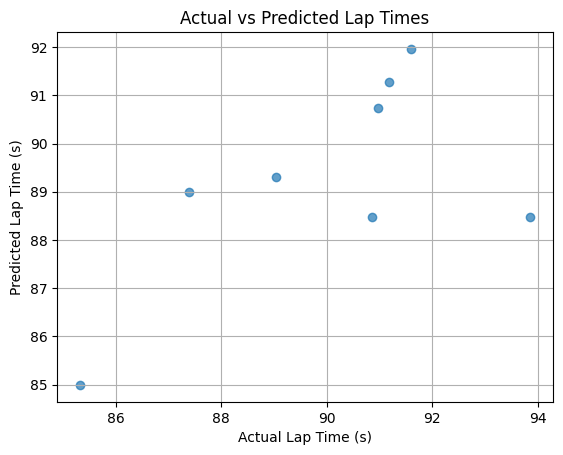

In [13]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Lap Time (s)")
plt.ylabel("Predicted Lap Time (s)")
plt.title("Actual vs Predicted Lap Times")
plt.grid(True)
plt.show()


📈 Enrich Data with Telemetry Features

In [15]:
enriched_data = []

# Correct way to iterate over laps
for _, lap in laps.iterlaps():
    lap_number = lap['LapNumber']
    lap_time = lap['LapTime'].total_seconds()
    compound = lap['Compound']
    tyre_life = lap['TyreLife']
    track_status = lap['TrackStatus']
    is_pb = lap['IsPersonalBest']

    # Get telemetry for this lap
    tel = lap.get_car_data().add_distance()

    # Aggregate telemetry
    avg_speed = tel['Speed'].mean()
    avg_throttle = tel['Throttle'].mean()
    avg_brake = tel['Brake'].mean()
    max_speed = tel['Speed'].max()

    enriched_data.append({
        'LapNumber': lap_number,
        'LapTimeSeconds': lap_time,
        'Compound': compound,
        'TyreLife': tyre_life,
        'TrackStatus': track_status,
        'IsPersonalBest': is_pb,
        'AvgSpeed': avg_speed,
        'MaxSpeed': max_speed,
        'AvgThrottle': avg_throttle,
        'AvgBrake': avg_brake
    })

# Convert to DataFrame and preprocess
df_telemetry = pd.DataFrame(enriched_data)
df_telemetry = pd.get_dummies(df_telemetry, columns=['Compound', 'TrackStatus'], drop_first=True)
df_telemetry.dropna(inplace=True)

print(df_telemetry.head())


   LapNumber  LapTimeSeconds  TyreLife  IsPersonalBest    AvgSpeed  MaxSpeed  \
0        8.0          96.830       8.0            True  193.457300     306.0   
1        9.0          94.315       9.0            True  197.436464     307.0   
2       10.0          92.650      10.0            True  203.729651     308.0   
3       11.0          92.453      11.0            True  204.603550     306.0   
4       12.0          91.591      12.0            True  202.790230     307.0   

   AvgThrottle  AvgBrake  Compound_MEDIUM  TrackStatus_12  TrackStatus_21  
0    57.567493  0.245179            False           False           False  
1    58.179558  0.234807            False           False           False  
2    62.255814  0.203488            False           False           False  
3    63.816568  0.192308            False           False           False  
4    63.114943  0.204023            False           False           False  


🧠 Train Improved Model with Telemetry Data

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Prepare feature matrix and target
X = df_telemetry.drop(columns=['LapTimeSeconds', 'LapNumber', 'IsPersonalBest'])
y = df_telemetry['LapTimeSeconds']

# Convert bools to float
X = X.astype(float)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📉 Mean Absolute Error: {mae:.3f} seconds")
print(f"📈 R² Score: {r2:.3f}")


📉 Mean Absolute Error: 0.699 seconds
📈 R² Score: 0.892


📉 Visualize Predictions from Improved Model

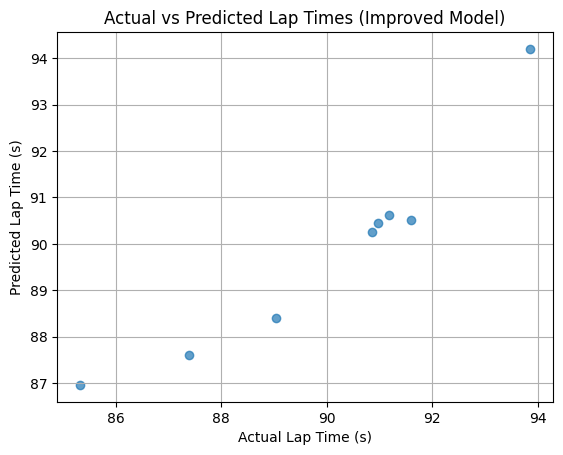

In [17]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Lap Time (s)")
plt.ylabel("Predicted Lap Time (s)")
plt.title("Actual vs Predicted Lap Times (Improved Model)")
plt.grid(True)
plt.show()


📌 Feature Importance Analysis

In [18]:
importances = model.feature_importances_
features = X.columns

# Display top contributors
sorted_idx = importances.argsort()[::-1]
for idx in sorted_idx:
    print(f"{features[idx]}: {importances[idx]:.4f}")


AvgSpeed: 0.6409
AvgThrottle: 0.2107
AvgBrake: 0.0690
TyreLife: 0.0562
Compound_MEDIUM: 0.0172
MaxSpeed: 0.0054
TrackStatus_12: 0.0006
TrackStatus_21: 0.0000
